<h1>Conditional Variational Autoencoder</h1>

Used: https://github.com/ogreen8084/deep_learning_stuff/blob/master/variational_autoencoder_tensorflow_rev_layers.ipynb,
https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/autoencoder.py, https://github.com/fastforwardlabs/vae-tf/blob/master/vae.py
For my next revision, I will clean it up with functions. This blog post was about is about conditional variational autoencoders: http://wiseodd.github.io/techblog/2016/12/17/conditional-vae/ The author's explanation is pretty self explanatory and adding the "conditional" part was a breeze. I'll add notes and clean it up with the next revision. 

In [1]:
#Dependencies:
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tf.__version__

'1.0.1'

In [3]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
def plotSubset(x_in, x_reconstructed, n=10, cols=None, outlines=True,
               save=True, name="subset", outdir="."):
    """Util to plot subset of inputs and reconstructed outputs"""
    n = min(n, x_in.shape[0])
    cols = (cols if cols else n)
    rows = 2 * int(np.ceil(n / cols)) # doubled b/c input & reconstruction

    plt.figure(figsize = (cols * 2, rows * 2))
    dim = 28 # assume square images

    def drawSubplot(x_, ax_):
        plt.imshow(x_.reshape([dim, dim]), cmap="Greys")
        if outlines:
            ax_.get_xaxis().set_visible(False)
            ax_.get_yaxis().set_visible(False)
        else:
            ax_.set_axis_off()

    for i, x in enumerate(x_in[:n], 1):
        # display original
        ax = plt.subplot(rows, cols, i) # rows, cols, subplot numbered from 1
        drawSubplot(x, ax)

    for i, x in enumerate(x_reconstructed[:n], 1):
        # display reconstruction
        ax = plt.subplot(rows, cols, i + cols * (rows / 2))
        drawSubplot(x, ax)

    plt.show()

#Source: https://github.com/fastforwardlabs/vae-tf/blob/master/plot.py

<h2>Conditional Concatenation:</h2> 
What makes a conditional variational autoencoder is the additional of a conditional variable. 
For the mnist example we are feeding the label data into the model along with the image data. We do so 
by concatenating the label and the image data. The labels are in one-hot vector form.
<h6>http://wiseodd.github.io/techblog/2016/12/17/conditional-vae/</h6>

In [5]:
mnist_concat = np.concatenate((mnist.train.images, mnist.train.labels), axis=1 )
mnist_concat.shape

(55000, 794)

<h2>Architecture Variables</h2>

In [1]:
input_dim = 784
input_dim_concat = 784 + 10 #
batch_size = 128
plots_outdir="./png"
lambda_l2_reg = 0.1
n_hidden1 = 600
n_hidden2 = 300
n_hidden3 = 20

NameError: name 'tf' is not defined

<h2>Encoder Weights</h2>
Going from 794 dimensions to 600 to 300 to 20 dimensions. 

In [7]:
enc_w1 = tf.get_variable("enc_1", shape=[input_dim_concat, n_hidden1], initializer=tf.contrib.layers.xavier_initializer())
enc_b1 = tf.Variable(tf.zeros(n_hidden1), dtype=tf.float32)
enc_w2 = tf.get_variable("enc_2", shape=[n_hidden1, n_hidden2], initializer=tf.contrib.layers.xavier_initializer())
enc_b2 = tf.Variable(tf.zeros(n_hidden2), dtype=tf.float32)
z_mean_w = tf.get_variable("z_mean_w", shape=[n_hidden2, n_hidden3], initializer=tf.contrib.layers.xavier_initializer())
z_mean_b = tf.Variable(tf.zeros(n_hidden3), dtype=tf.float32)
z_log_sigma_w = tf.get_variable('log_sigma_w', shape=[n_hidden2, n_hidden3], initializer=tf.contrib.layers.xavier_initializer())
z_log_sigma_b = tf.Variable(tf.zeros(n_hidden3), dtype=tf.float32)

<h2>Decoder Weights</h2>
At the beginning of the decoder, we concatenate the labels once again to incorporate them into the decoder model.
This model goes from 20 + 10 dimensions to 300 dimensions to 600 dimensions to 784 dimensions

In [8]:

dec_w1 = tf.get_variable("dec_1", shape=[n_hidden3 + 10, n_hidden2], initializer=tf.contrib.layers.xavier_initializer())
dec_b1 = tf.Variable(tf.zeros([n_hidden2], dtype=tf.float32))
dec_w2 = tf.get_variable("dec_2", shape=[n_hidden2, n_hidden1], initializer=tf.contrib.layers.xavier_initializer())
dec_b2 = tf.Variable(tf.zeros([n_hidden1], dtype=tf.float32))
dec_w3 = tf.get_variable("dec_3", shape=[n_hidden1, input_dim], initializer=tf.contrib.layers.xavier_initializer())
dec_b3 = tf.Variable(tf.zeros([input_dim], dtype=tf.float32))

<h2>ELU Activation</h2>
We are using the ELU. The ELU is supposed to help the model avoid dead weights. 

The exponential linear unit (ELU) with 0 < α is

f(x) = 
x if x > 0 or 
α (exp(x) − 1) if x ≤ 0
 
f'(x) =
1 if x > 0 or 
f(x) + α if x ≤ 0

https://arxiv.org/pdf/1511.07289.pdf

In [9]:
x_in = tf.placeholder(tf.float32, (None, input_dim_concat))
x_ = tf.placeholder(tf.float32, (None, input_dim))
label_ = tf.placeholder(tf.float32, (None, 10))

enc_layer_1 = tf.nn.elu(tf.add(tf.matmul(x_in, enc_w1), enc_b1))
enc_layer_2 = tf.nn.elu(tf.add(tf.matmul(enc_layer_1, enc_w2), enc_b2))


In [10]:
z_mean = tf.nn.elu(tf.add(tf.matmul(enc_layer_2, z_mean_w), z_mean_b))
z_log_sigma_sq = tf.nn.elu(tf.add(tf.matmul(enc_layer_2, z_log_sigma_w), z_log_sigma_b))
eps = tf.random_normal(tf.stack([tf.shape(enc_layer_2)[0], n_hidden3]), 0, 1, dtype=tf.float32)

In [11]:
z = tf.add(z_mean, tf.multiply(tf.sqrt(tf.exp(z_log_sigma_sq)), eps))
z_cond = tf.concat([z, label_], axis=1)

In [12]:
dec_layer_1 = tf.nn.elu(tf.add(tf.matmul(z_cond, dec_w1), dec_b1))
dec_layer_2 = tf.nn.elu(tf.add(tf.matmul(dec_layer_1, dec_w2), dec_b2))

reconstruction = tf.nn.sigmoid(tf.add(tf.matmul(dec_layer_2, dec_w3), dec_b3))
reconstr_loss = 0.5 * tf.reduce_sum(tf.pow(tf.subtract(reconstruction, x_), 2.0))
latent_loss = -0.5 * tf.reduce_sum(1 + z_log_sigma_sq 
                                  -tf.square(z_mean)
                                  -tf.exp(z_log_sigma_sq), 1)


In [13]:
cost = tf.reduce_mean(reconstr_loss + latent_loss)
optimizer = tf.train.AdamOptimizer().minimize(cost)


In [14]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

Iteration: 0 cost: 11765.376953
Samples:


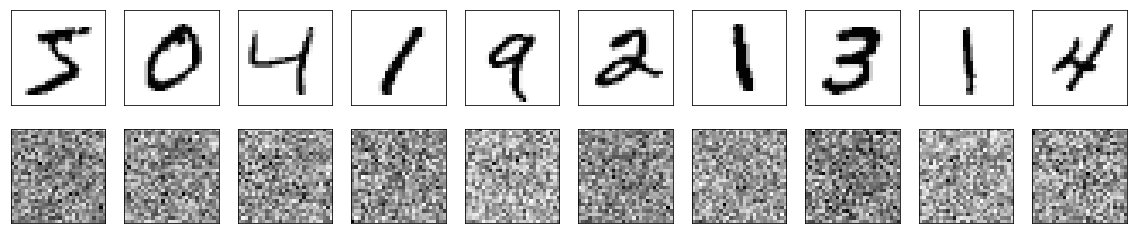

Iteration: 2000 cost: 747.295288
Samples:


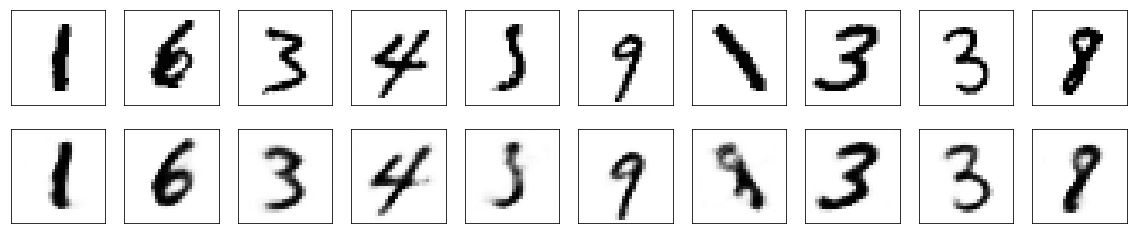

Iteration: 4000 cost: 698.195312
Samples:


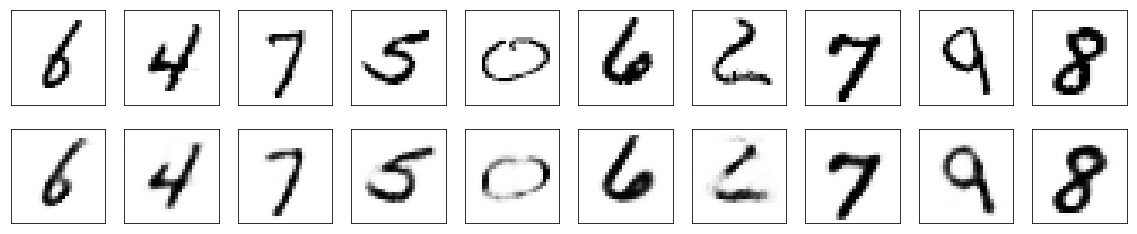

Iteration: 6000 cost: 685.046997
Samples:


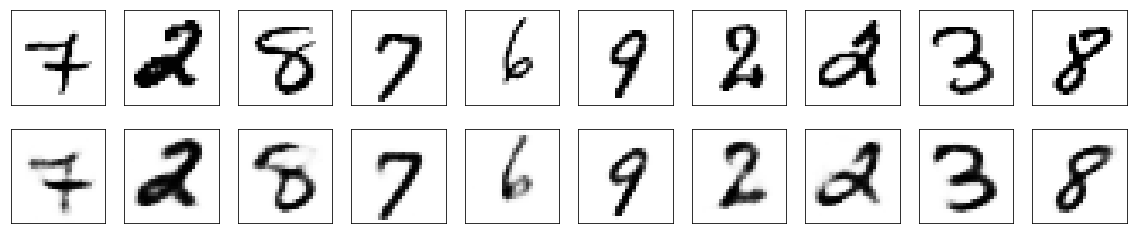

Iteration: 8000 cost: 641.890198
Samples:


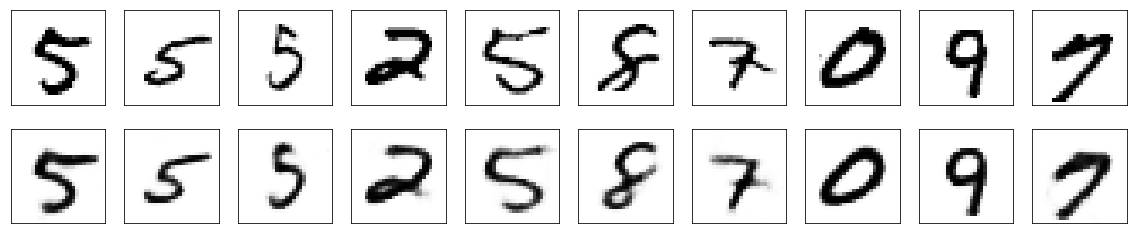

Iteration: 10000 cost: 642.738342
Samples:


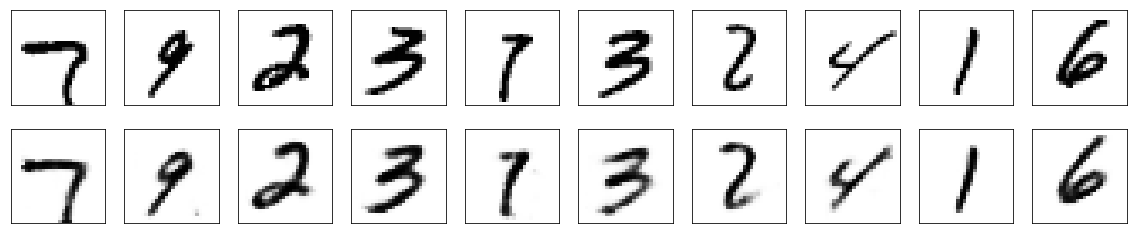

Iteration: 12000 cost: 586.489014
Samples:


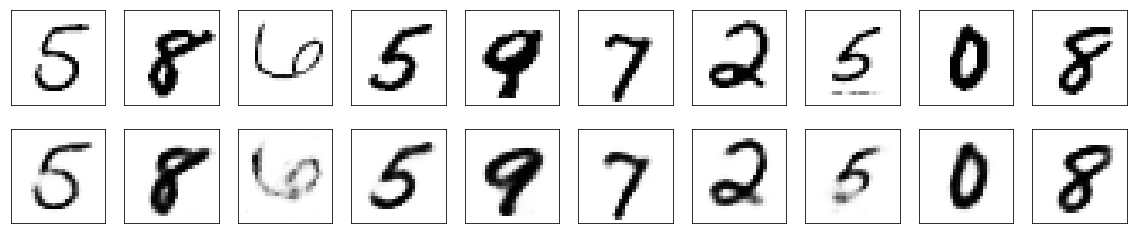

Iteration: 14000 cost: 589.412903
Samples:


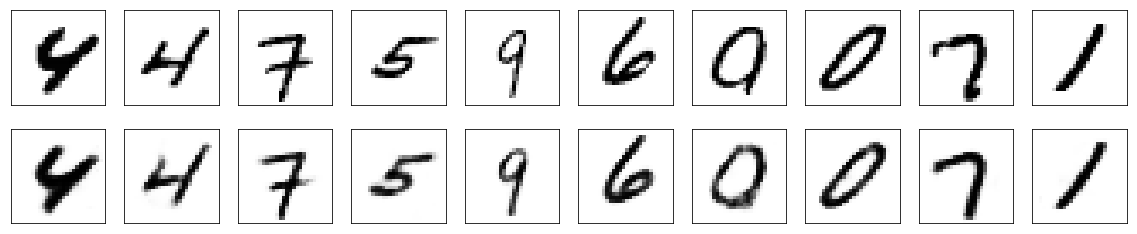

Iteration: 16000 cost: 592.813293
Samples:


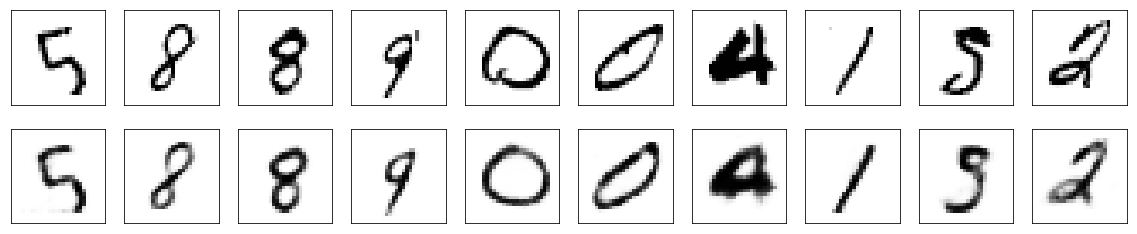

Iteration: 18000 cost: 627.629395
Samples:


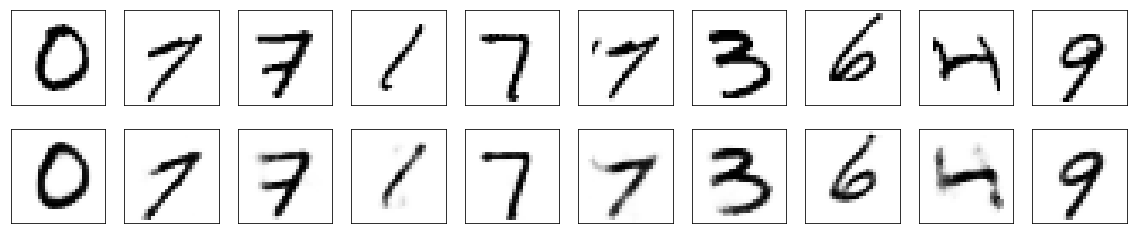

Iteration: 20000 cost: 579.339722
Samples:


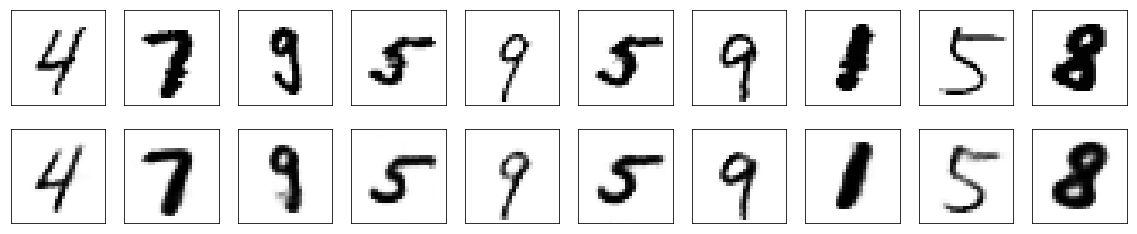

In [15]:
for i in range(20001):
    x, y= mnist.train.next_batch(batch_size)
    input_ = np.concatenate((x, y), axis=1)

    _, c = sess.run([optimizer, cost], feed_dict={x_in: input_, x_: x, label_: y})
    if i % 2000 == 0:
        print("Iteration: %d cost: %f" %(i, c))

        print("Samples:")

        x2, y2 = mnist.validation.next_batch(batch_size)
        test_input = np.concatenate((x2, y2), axis=1)
        feed_dict2 = {x_in: test_input, x_ : x2, label_: y2}
        fetches2 = [reconstruction, cost]
        x_prime2, cost2 = sess.run(fetches2, feed_dict2)
        plotSubset(x2, x_prime2, n=10, name="cv",
                        outdir=plots_outdir)


In [16]:
#conditioning on zero
dig_to_gen = 0
dig_list = np.array([dig_to_gen] * batch_size)
dig_one_hot = np.zeros((batch_size, 10))
dig_one_hot[np.arange(128), dig_list] = 1

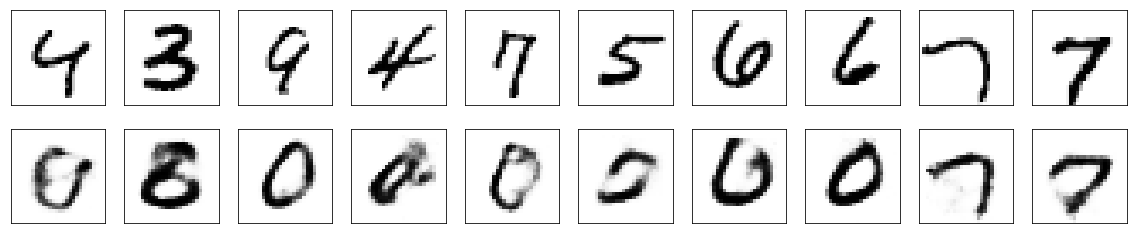

In [17]:
x2, _ = mnist.validation.next_batch(batch_size)
test_input = np.concatenate((x2, y2), axis=1)
feed_dict2 = {x_in: test_input, x_ : x2, label_: dig_one_hot}
fetches2 = [reconstruction, cost]
x_prime2, cost2 = sess.run(fetches2, feed_dict2)
plotSubset(x2, x_prime2, n=10, name="cv",
                outdir=plots_outdir)
